In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

df = pd.read_csv("../meteo_data.csv")
df.index = pd.to_datetime(df.DATE)
del df['DATE']

required_cols = ['SOLAR_RADIATION']
df = df[required_cols]
df

,SOLAR_RADIATION
DATE,
2020-06-01 15:00:00,134.0
2020-06-01 16:00:00,272.0
2020-06-01 17:00:00,132.0
2020-06-01 18:00:00,247.0
2020-06-01 19:00:00,109.0
...,...
2024-05-31 10:00:00,380.0
2024-05-31 11:00:00,417.0
2024-05-31 12:00:00,566.0


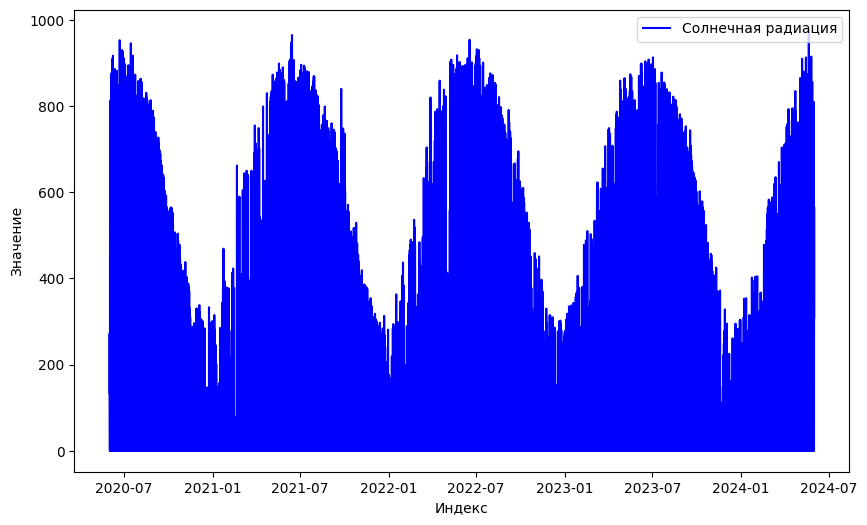

In [11]:
temp = df['SOLAR_RADIATION']

plt.figure(figsize=(10, 6))
plt.plot(df['SOLAR_RADIATION'], label='Солнечная радиация', color='blue')

# Настройка графика
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()

# Показать график
plt.show()

In [12]:
# [[1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]   [11]
# [[2], [3], [4], [5], [6], [7], [8], [9], [10], [11]]  [12]
# [[3], [4], [5], [6], [7], [8], [9], [10], [11], [12]] [13]
def df_to_X_y(df, window_size=24):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

WINDOW_SIZE = 24
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)

X_train1, y_train1 = X1[:26250], y1[:26250]
X_val1, y_val1 = X1[26250:30625], y1[26250:30625]
X_test1, y_test1 = X1[30625:], y1[30625:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((26250, 24, 1), (26250,), (4375, 24, 1), (4375,), (4376, 24, 1), (4376,))

In [13]:
model2 = Sequential()
model2.add(InputLayer((WINDOW_SIZE, 1)))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(32))
model2.add(Dropout(0.5))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(8, activation='relu'))
model2.add(Dense(1, activation='relu'))
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 24, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 24, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,009 (246.13 KB)

 Trainable params: 63,009 (246.13 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Настройки обратного вызова и компиляции модели
model_save_path = 'model2/model2-SOLAR_RADIATION.keras'
cp2 = ModelCheckpoint(model_save_path, save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [16]:
# Обучение модели
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp2])

Epoch 1/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 38s 37ms/step - loss: 65543.2266 - root_mean_squared_error: 255.9576 - val_loss: 75198.1719 - val_root_mean_squared_error: 274.2228
Epoch 2/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - loss: 49968.4219 - root_mean_squared_error: 223.3696 - val_loss: 48243.6875 - val_root_mean_squared_error: 219.6445
Epoch 3/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - loss: 30620.3613 - root_mean_squared_error: 174.9168 - val_loss: 26275.4551 - val_root_mean_squared_error: 162.0971
Epoch 4/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 18951.5000 - root_mean_squared_error: 137.5071 - val_loss: 15363.2754 - val_root_mean_squared_error: 123.9487
Epoch 5/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - loss: 12291.9199 - root_mean_squared_error: 110.8362 - val_loss: 9404.7959 - val_root_mean_squared_error: 96.9783
Epoch 6/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - loss: 9529.1016 - root_mean_squared_error: 97.5534 - val_loss: 6905.6802 - val_root_me

In [17]:
# Сохранение всей модели на диск
model_save_path = 'model2/model2-SOLAR_RADIATION.keras'
model2.save(model_save_path)
print(f"Модель сохранена в {model_save_path}")

Модель сохранена в model2/model2-solar-radiation.keras


In [23]:
from keras.models import load_model
model2 = load_model('../three_hour/model2/model2-SOLAR_RADIATION.keras')

In [24]:
# Прогнозирование на тестовых данных
y_pred = model2.predict(X_test1)

# Вывод предсказаний
print(y_pred)

137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step
[[3.0084234e-01]
 [2.5152129e-01]
 [3.0365858e+00]
 ...
 [5.9363800e+02]
 [6.6979156e+02]
 [5.4854779e+02]]


In [25]:
# Прогнозирование на будущее
def predict_future(model, last_known_data, last_known_dates, steps=3, window_size=24):
    predictions = []
    future_dates = pd.date_range(start=last_known_dates[-1], periods=steps + 1, freq='h')[1:]
    
    current_data = last_known_data.tolist()
    
    for _ in range(steps):
        input_data = np.array(current_data[-window_size:]).reshape(1, window_size, 1)
        prediction = model.predict(input_data)
        predictions.append(prediction[0, 0])
        current_data.append(prediction[0, 0])
    
    return future_dates, predictions

# Последние известные данные и даты
last_known_data = temp.values[-WINDOW_SIZE:]
last_known_dates = temp.index[-WINDOW_SIZE:]

# Прогнозирование на 3 шага вперед
future_steps = 1
future_dates, predictions = predict_future(model2, last_known_data, last_known_dates, future_steps, WINDOW_SIZE)

# Вывод предсказаний с датами
for date, pred in zip(future_dates, predictions):
    print(f"{date}: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2024-05-31 15:00:00: 384.21978759765625


137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step


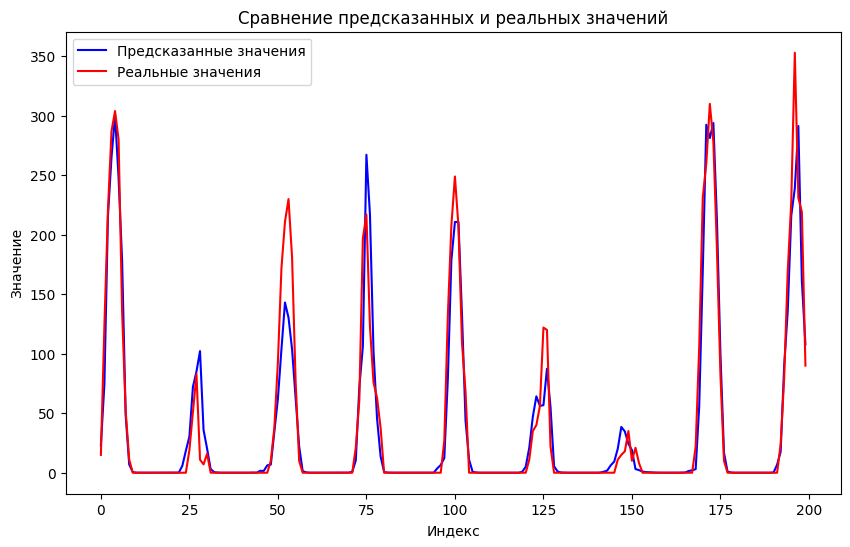

In [26]:
# Предсказание на тестовом наборе данных
y_pred1 = model2.predict(X_test1)

# Построение графика предсказанных и реальных значений
plt.figure(figsize=(10, 6))
plt.plot(y_pred1[700:900], label='Предсказанные значения', color='blue')
plt.plot(y_test1[700:900], label='Реальные значения', color='red')
plt.title('Сравнение предсказанных и реальных значений')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [27]:
# Оценка MAE
mae = mean_absolute_error(y_test1, y_pred1)

# Оценка MSE
mse = mean_squared_error(y_test1, y_pred1)

# Оценка RMSE
rmse = np.sqrt(mse)

# Оценка R^2
r2 = r2_score(y_test1, y_pred1)

print("Средняя абсолютная ошибка (MAE):", mae)
print("Средняя квадратичная ошибка (MSE):", mse)
print("Корень из среднеквадратичной ошибки (RMSE):", rmse)
print("Коэффициент детерминации (R^2):", r2)

Средняя абсолютная ошибка (MAE): 20.893552691377767
Средняя квадратичная ошибка (MSE): 2433.4516216527536
Корень из среднеквадратичной ошибки (RMSE): 49.330027586174666
Коэффициент детерминации (R^2): 0.9400746048662755
